In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
# set the torch device as mac 'mps'
device = torch.device('mps')

# read the names.txt file into a list words and split the lines
words = open('names.txt').read().splitlines()

# build the vocabulary
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [3]:
# build the dataset
block_size = 3
X, Y = [], []

# iterate through first 5 words
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X, device=device)
Y = torch.tensor(Y, device=device)

In [7]:
# At this point, X is the context and Y is the target
# by virtue of the length of the names, and how many names we iterated through
# we got 32 context-target pairs
print(X.shape, Y.shape) 

torch.Size([228146, 3]) torch.Size([228146])


In [59]:
# According to the paper we are going to defeat dimensionality by embedding the context
# into a lower dimensional space that is initialized randomly as C
C = torch.randn((27, 2), device=device, requires_grad=True)

In [60]:
# The embedding matrix C is a 27x2 matrix, where each row is the embedding of a character
# The first row is the embedding of the '.' character
# The second row is the embedding of the 'A' character
# The third row is the embedding of the 'B' character
# ...
emb = C[X]

# here emb is a 32x3x2 matrix
# there are 32 contexts
# each row represents a context
# each row has 3 characters
# each character is represented by a 2 dimensional vector
emb.shape

torch.Size([32, 3, 2])

In [75]:
# Construct the MLP

# After embedding the context we need to determine how many inputs there are to the MLP
# The number of inputs is the number of characters in the context times the dimensionality of the embedding
# In this case, the number of inputs is 3 * 2 = 6

# We have to determine how many neurons are in the hidden layer but it's arbitrary
# We will use 100 neurons

W1 = torch.randn((6, 100), device=device, requires_grad=True)

# The number of biases is the number of neurons in the hidden layer, which is 100
b1 = torch.randn(100, device=device, requires_grad=True)

In [62]:
# Roughly speaking we would like to take the emb and multiply it by the weights and add the bias but...
# it's not that simple 
emb @ W1 + b1

RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x2 and 6x100)

In [65]:
# The emb is a 32x3x2 matrix and the weights are a 6x100 matrix
print(emb.shape, W1.shape, b1.shape)

torch.Size([32, 3, 2]) torch.Size([6, 100]) torch.Size([100])


In [66]:
# If emb were a 32x6 matrix, we could multiply it by the weights and add the bias
# we can do this by reshaping the emb matrix, or concatenating the 3x2 matrices into a 6x1 matrix

# One way is using concatenation
# To start off we want to grab each character of the context
# We can do this by indexing the emb matrix

# This example grabs all the contexts, the first character of each context, and all the dimensions of the embedding
emb[:, 0, :]

# This example grabs all the contexts, the second character of each context, and all the dimensions of the embedding
emb[:, 1, :]

# This example grabs all the contexts, the third character of each context, and all the dimensions of the embedding
emb[:, 2, :]

# To concatenate the 3x2 matrices into a 6x1 matrix we can use the cat method
# It takes a dim argument which is the dimension along which to concatenate
# emb[:, 0, :].shape is 32x2
# We don't want to concatenate along the 32 dimension, we want to concatenate along the 2 dimension
# So we pass dim=1 to the cat method
emb_concatenated = torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1)
print(emb_concatenated.shape)

torch.Size([32, 6])


In [67]:
# Our first pass at using .cat is a little ugly because it will not generalize to contexts/ block_size of different length
# We can use torch.unbind to unbind the emb matrix along the 1 dimension, returning a list of 3x2 matrices  
emb_concatenated_with_unbind = torch.cat(torch.unbind(emb, dim=1), dim=1)
emb_concatenated_with_unbind.shape

torch.Size([32, 6])

In [68]:
# But there is an even more efficient way to do this using the view method
# Say we start off with a tensor of a range of 18 numbers
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [69]:
# As long as the number of elements in the tensor is the same, we can reshape it
a.view(2,9)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

In [70]:
a.view(3,3,2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [71]:
# This is due to the torch underlying storage
# Each tensor has a storage, which is a contiguous chunk of memory
# When we grab a slice of a tensor we can walk by a stride, or step size
# The stride is the number of elements to skip to get to the next element
# This fundamental concept, along with storage offsets, and shapes, are what allows us to reshape tensors very very efficeintly
# See ezyang's blog post for more details
# http://blog.ezyang.com/2019/05/pytorch-internals/
emb_view = emb.view(32, 6)
emb_view == emb_concatenated

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [72]:
# Another way to do this that doesn't include magic numbers is to use the -1
# the number of elements in the tensor must be the same, so pytorch will infer
# the number of elements in the first dimension

# This way is preferred because it is more efficient memory-wise, 
# the cat method creates a new tensor and copies the data
emb_view == emb.view(-1, 6)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [77]:
# Back to the plot
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h

tensor([[ 0.9632,  0.9654, -0.6559,  ..., -0.9214,  0.8202,  0.3971],
        [ 0.9796,  0.9947, -0.8647,  ..., -0.9746,  0.7461, -0.4896],
        [ 0.9732,  0.9986, -0.9186,  ..., -0.9694,  0.3863, -0.9663],
        ...,
        [ 1.0000,  1.0000,  0.9000,  ...,  1.0000, -0.3591,  0.9608],
        [-1.0000, -0.9992,  0.3101,  ..., -0.0590,  0.9969,  0.9512],
        [-0.9999,  0.7941, -0.7231,  ...,  0.3130,  0.9914,  1.0000]],
       device='mps:0', grad_fn=<TanhBackward0>)

In [54]:
h.shape

torch.Size([32, 100])

In [ ]:
# Also remember that when you are broadcasting to check that it's doing what you think it is
# emb.view(-1, 6) @ W1 is a 32x100 matrix
# b1 is 100
# the broadcast will right align the two tensors
# 32, 100
#   , 100

# The blank space is where the broadcast will happen, it will change to 1 making it
# 32, 100
#  1, 100
# and then it will copy vertically for every one of the rows of 32 and do an element-wise addition

In [78]:
# Now let's definte the output layer
# The number of inputs is the number of neurons in the hidden layer, which is 100
# The number of outputs is the number of characters in the vocabulary, which is 27
W2 = torch.randn((100, 27), device=device, requires_grad=True)
b2 = torch.randn(27, device=device, requires_grad=True)

# The output layer is a linear layer of logits
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [79]:
# Our next step is to softmax the logits exponentiating then normalizing
counts = logits.exp()
probabilities = counts / counts.sum(dim=1, keepdim=True)
probabilities.shape

torch.Size([32, 27])

In [81]:
probabilities[0].sum()

tensor(1.0000, device='mps:0', grad_fn=<SumBackward0>)

In [ ]:
# What is the probabilities variable?
# It is a 32x27 matrix
# Each row represents a context of 3 characters
# Each row has 27 probabilities, one for each character in the vocabulary that the context could be followed by

In [82]:
# Now let's calculate our loss using Y
# Y is a 32x1 matrix
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0],
       device='mps:0')

In [83]:
# Each element of Y is the correct letter that follows the context
# We want to calculate the probability of the correct letter against each calculated probability
# We can do this by indexing the probabilities matrix with Y
# This will return a 32x1 matrix
# Each element is the probability of the correct letter

# torch.arange(32) is a 32x1 matrix of the numbers 0-31
torch.arange(32)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [85]:
# Indexing into probabilities using torch.arange(32) will return a 32x27 matrix
# Each row tells you the probabilities of each letter for that context
probabilities[torch.arange(32)].shape

torch.Size([32, 27])

In [86]:
# Y tells you what the correct letter is for each context
# It is an integer that we can use to index into each row of probabilities[torch.arange(32)]
probabilities[torch.arange(32), Y]

tensor([4.6299e-04, 1.1091e-04, 6.4675e-03, 1.9027e-01, 3.1007e-16, 5.1122e-01,
        6.4685e-16, 1.6151e-05, 3.2409e-05, 1.1037e-04, 5.3965e-07, 9.6247e-15,
        4.3326e-01, 9.2833e-10, 7.2484e-06, 2.0049e-13, 3.2795e-02, 6.8007e-04,
        4.9042e-07, 1.7786e-02, 3.4683e-01, 4.5049e-09, 1.6408e-02, 9.6769e-01,
        2.8327e-15, 5.2761e-04, 3.2929e-05, 9.6498e-07, 3.6665e-08, 6.4184e-09,
        1.0722e-08, 3.3731e-15], device='mps:0', grad_fn=<IndexBackward0>)

In [88]:
# Basically all of those values should be close to 1
# To get the negative log likelihood we take the log of the probabilities, then take the mean, then take the negative
nll = -probabilities[torch.arange(32), Y].log().mean()
nll.item()

13.790632247924805

In [4]:
# Let's rewrite all this in a one code block to make it easier to understand
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g, device=device, requires_grad=True)
W1 = torch.randn((6, 100), generator=g, device=device, requires_grad=True)
b1 = torch.randn(100, generator=g, device=device, requires_grad=True)
W2 = torch.randn((100, 27), generator=g, device=device, requires_grad=True)
b2 = torch.randn(27, generator=g, device=device, requires_grad=True)
params = [C, W1, b1, W2, b2]
sum(p.nelement() for p in params)

3481

In [5]:
emb = C[X] # 32x3x2
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # 32x100
logits = h @ W2 + b2 # 32x27
counts = logits.exp() # 32x27
probabilities = counts / counts.sum(dim=1, keepdim=True) # 32x27
loss = -probabilities[torch.arange(len(X)), Y].log().mean() # 1x1
loss.item()

20.2970027923584

In [117]:
# Now let's rewrite this using the nn.functional module
F.cross_entropy(logits, Y).item()
loss.item() == F.cross_entropy(logits, Y).item()
loss.shape()

ValueError: Expected input batch_size (6) to match target batch_size (228146).

In [6]:
for _ in range(10):
    # Forward pass
    emb = C[X] # 32x3x2
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # 32x100
    logits = h @ W2 + b2 # 32x27
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    # Backward pass
    for p in params:
        p.grad = None
    loss.backward()
    # update
    for p in params:
        p.data -= 0.1 * p.grad

20.2970027923584
18.04897689819336
16.251262664794922
15.066499710083008
13.95138931274414
13.294294357299805
12.424456596374512
11.778600692749023
11.43054485321045
10.748379707336426


In [107]:
# Our learning rate is sort of arbitrary, let's try to find it through experimentation
# let's create a learning rate exponent using linspace
lre = torch.linspace(-3, 0, 1000)
# and then use the lre to create a learning rate
lrs = 10 ** lre
lri = []
lossi = []
for _ in range(1000):
    # let's also create a minbatch construct
    ix = torch.randint(0, X.shape[0], (32,))

    # Forward pass
    emb = C[X[ix]] # 32x3x2
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # 32x100
    logits = h @ W2 + b2 # 32x27
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())
    # Backward pass
    for p in params:
        p.grad = None
    loss.backward()
    # update
    lr = 0.1
    for p in params:
        p.data -= lr * p.grad

    # track stats
    # lri.append(lre[i])
    # lossi.append(loss.item())

16.306503295898438
14.739761352539062
18.682445526123047
20.173892974853516
18.454864501953125
14.628962516784668
18.915271759033203
16.667339324951172
17.63689613342285
17.52914810180664
14.354486465454102
16.536197662353516
17.736717224121094
15.614764213562012
17.791118621826172
16.756061553955078
15.964405059814453
16.684738159179688
15.770929336547852
16.53322982788086
16.006805419921875
17.923566818237305
15.263476371765137
15.39060115814209
15.21214485168457
14.782210350036621
15.212835311889648
15.08761978149414
16.30282974243164
16.09217071533203
16.97829818725586
13.135651588439941
15.589098930358887
15.580193519592285
14.213008880615234
15.959938049316406
16.7843017578125
15.041219711303711
15.280984878540039
15.069761276245117
16.292003631591797
17.141212463378906
13.162216186523438
15.244680404663086
16.716819763183594
18.41709327697754
17.71023941040039
16.635692596435547
13.530391693115234
13.95034408569336
16.228084564208984
14.266618728637695
16.586715698242188
16.9826

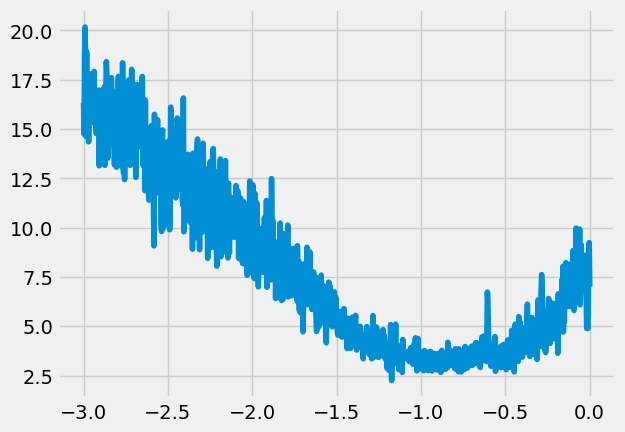

In [108]:
plt.plot(lri, lossi)